# Data Exploration for Yelp User Dataset

This is a notebook that explores the sample User Yelp dataset provided by Kaggle (https://www.kaggle.com/yelp-dataset/yelp-dataset).
 
This covers user data that maps to users compliments, date of joining and review metadata among other things.

### Imports and Parameters

In [1]:
pip install findspark py4j ipywidgets matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [49]:
# For local installations, use findspark to locate Spark.
import findspark
findspark.init("/Users/ana/server/spark-3.0.1-bin-hadoop2.7")

import pyspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import isnan, when, count, col, year

import pandas as pd
import ipywidgets as widgets
from IPython.display import display

from matplotlib import pyplot as plt
%matplotlib inline

#Seaborn for data visualization
import seaborn as sns

# Pandas Options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [4]:
sc = pyspark.SparkContext(appName="data-exploration-yelp")

spark = SparkSession(sc)

### Parameters

In [5]:
yelp_user = "../../yelp-raw/yelp_academic_dataset_user.json"

### Initial Data Exploration

#### User Dataset Overview

In [6]:
user_df = spark.read.json(yelp_user)

In [7]:
user_df.show(5,False)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------------------------------+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
user_df.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [9]:
# User ID's are unique, so we know we have just under 2 million users.
user_df.count()

1968703

#### Move "friends" to the end of the dataframe

In [57]:
# Friends is a relatively long column, move it to the end of the dataframe for easier viewing.
clean_user_df = user_df.select("name", "user_id", "average_stars", "review_count", "elite", "fans", "yelping_since", "useful", "cool", "funny", "compliment_cool", "compliment_cute", "compliment_funny", "compliment_hot", "compliment_list", "compliment_plain", "compliment_profile", "compliment_writer", "compliment_photos", "compliment_note", "compliment_more", "friends")

In [58]:
clean_user_df.show(5, False)

+--------+----------------------+-------------+------------+--------------------------------------------+----+-------------------+------+----+-----+---------------+---------------+----------------+--------------+---------------+----------------+------------------+-----------------+-----------------+---------------+---------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
clean_user_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- friends: string (nullable = true)



#### Null User Column Checks

Here we check for any missing data in the dataset. Fortunately with this user dataset, we have full coverage of every column.

In [60]:
# Creates new dataframe that counts all nulls within a column iteratively.
null_user_df = clean_user_df.select([count(when(col(c).isNull(), c)).alias(c) for c in clean_user_df.columns])
null_user_df

DataFrame[name: bigint, user_id: bigint, average_stars: bigint, review_count: bigint, elite: bigint, fans: bigint, yelping_since: bigint, useful: bigint, cool: bigint, funny: bigint, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, compliment_photos: bigint, compliment_note: bigint, compliment_more: bigint, friends: bigint]

In [61]:
null_user_pd = null_user_df.toPandas()

In [62]:
null_user_pd

,name,user_id,average_stars,review_count,elite,fans,yelping_since,useful,cool,funny,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_plain,compliment_profile,compliment_writer,compliment_photos,compliment_note,compliment_more,friends
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Mapping Value Counts

Here we map various value counts of each column. A few observations:

1. User ID's are unique per row. No duplicate user ID's to worry about
2. Review counts decrease nearly linearly. For every additional review count, the number of that amount of reviews go down. Eg 1 review has the most value counts, then two, and so on.
3. Friends are uncommon and most people have none on Yelp. We probably want to avoid putting too much weight on any friendship relations for this dataset.
4. Fans and elite are rare, but probably good measures of "exceptional" reviews. May be useful to weight these in some way.

In [63]:
# Create a widget for mapping the value counts for individual columns
dropdown_columns = widgets.Dropdown(options = clean_user_df.columns)

output_column = widgets.Output()

def dropdown_columns_event_handler(change):
    """
    Handles the column changes for each column selection and gets the value counts
    """
    output_column.clear_output()
    
    clean_user_df.groupBy(change.new).count().sort(col("count").desc()).show(50, False)

dropdown_columns.observe(dropdown_columns_event_handler, names='value')
display(dropdown_columns)

Dropdown(options=('name', 'user_id', 'average_stars', 'review_count', 'elite', 'fans', 'yelping_since', 'usefu…

+-------------------------------------------------+-------+
|elite                                            |count  |
+-------------------------------------------------+-------+
|                                                 |1892742|
|2018                                             |11611  |
|2017,2018                                        |10196  |
|2016,2017,2018                                   |6369   |
|2015,2016,2017,2018                              |4762   |
|2016,2017                                        |2273   |
|2014,2015,2016,2017,2018                         |2236   |
|2012,2013,2014,2015,2016,2017,2018               |1902   |
|2015,2016                                        |1871   |
|2015,2016,2017                                   |1618   |
|2013,2014,2015,2016,2017,2018                    |1552   |
|2017                                             |1380   |
|2012                                             |1101   |
|2011,2012,2013,2014,2015,2016,2017,2018

### Data Visualization Exploration

In [17]:
stars_count_df = clean_user_df.groupBy(col("average_stars")).count().sort(col("count").desc())
stars_count_df.show(10, False)

+-------------+------+
|average_stars|count |
+-------------+------+
|5.0          |375189|
|1.0          |159534|
|3.0          |113082|
|4.0          |106765|
|3.67         |53113 |
|2.0          |44367 |
|4.5          |40239 |
|3.5          |34930 |
|2.33         |27081 |
|4.33         |26360 |
+-------------+------+
only showing top 10 rows



In [76]:
stars_pd = clean_user_df.select(col('average_stars')).toPandas()
stars_pd.head(10)

,average_stars
0,3.57
1,3.84
2,3.44
3,3.08
4,4.37
5,2.88
6,4.00
7,3.63
8,3.75
9,4.10


#### Average review

With reviews, we see that its on more of a continous scale from 1 to 5. We also want to be careful about overbucketing and just grouping these into simpler ranges until we understand the distribution of averages.

We see that 1.0, 2.0, 3.0, 4.0, and 5.0 have the highest values as people leave 1 review most often, hence averages being concentrated there. We also see that most reviews skew from 3 to 5, where lower than 3 is less likely until we get to 1 star. It does seem like for execptionally bad experiences, people are willing to leave a one star. 

For recommending businesses we'll need to keep this in mind as scaling is often more positive than negative, but a 3 star place is in reality probably a lot less desirable than a 4 star for recommendations.

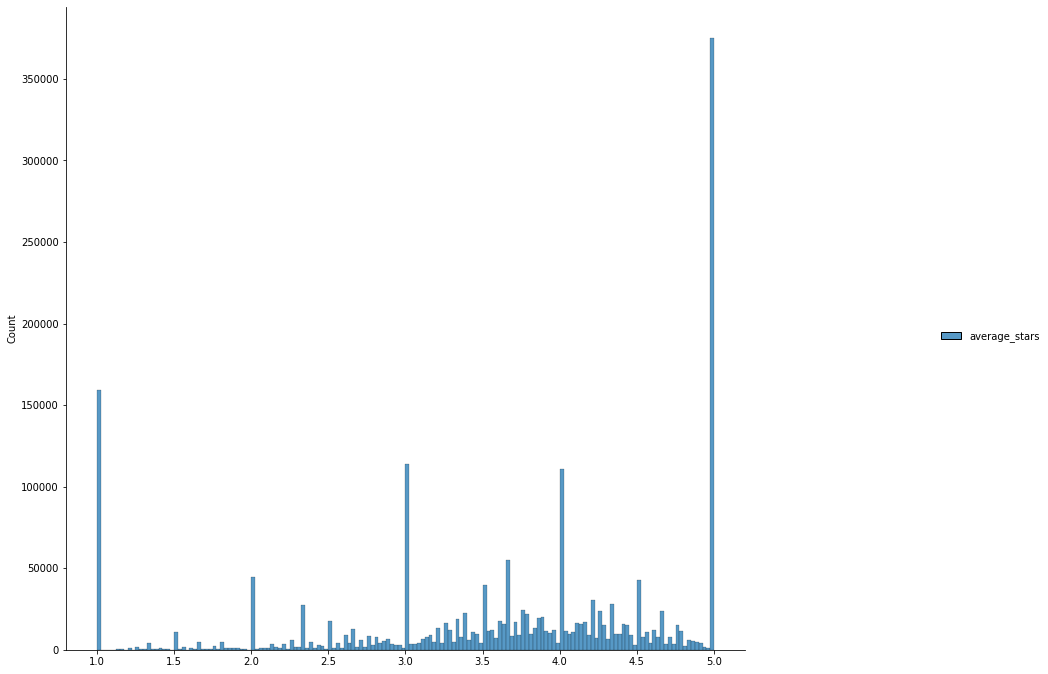

In [77]:
ax = sns.displot(stars_pd)

fig = plt.gcf()
fig.set_size_inches(16, 10)

plt.show()

#### Graph various compliment counts

Here we get the counts of all compliments for users that are above zero and graph them.

In [31]:
funny_count = clean_user_df.select("compliment_funny").filter(col('compliment_funny') > 0).count()
cool_count = clean_user_df.select("compliment_cool").filter(col('compliment_cool') > 0).count()
plain_count = clean_user_df.select("compliment_plain").filter(col('compliment_plain') > 0).count()
hot_count = clean_user_df.select("compliment_hot").filter(col('compliment_hot') > 0).count()
cute_count = clean_user_df.select("compliment_cute").filter(col('compliment_cute') > 0).count()
list_count = clean_user_df.select("compliment_list").filter(col('compliment_list') > 0).count()
profile_count = clean_user_df.select("compliment_profile").filter(col('compliment_profile') > 0).count()
writer_count = clean_user_df.select("compliment_writer").filter(col('compliment_writer') > 0).count()
photos_count = clean_user_df.select("compliment_photos").filter(col('compliment_photos') > 0).count()
note_count = clean_user_df.select("compliment_note").filter(col('compliment_note') > 0).count()
more_count = clean_user_df.select("compliment_more").filter(col('compliment_more') > 0).count()

In [32]:
print(funny_count, cool_count, plain_count, hot_count, cute_count, list_count, profile_count, writer_count, photos_count, note_count, more_count)

227547 227547 336942 161161 47954 19676 55597 184489 118342 305794 143964


In [33]:
# Create Array list of each count for us to transform into a Pandas Dataframe.
count_data = [['funny_count', funny_count], ['cool_count', cool_count], ['plain_count', plain_count], 
        ['hot_count', hot_count], ['cute_count', cute_count],  ['list_count', list_count], 
        ['profile_count', profile_count], ['writer_count', writer_count], ['photos_count', photos_count], 
        ['note_count', note_count], ['more_count', more_count]]

# Map the array values into pandas.
user_review_count_pd = pd.DataFrame(count_data, columns = ['name', 'count']) 

In [34]:
sorted_user_review_count_pd = user_review_count_pd.sort_values(by="count", ascending=True)
sorted_user_review_count_pd

,name,count
5,list_count,19676
4,cute_count,47954
6,profile_count,55597
8,photos_count,118342
10,more_count,143964
3,hot_count,161161
7,writer_count,184489
0,funny_count,227547
1,cool_count,227547
9,note_count,305794


#### Compliment Graphing

Here we see plain compliments being the most common type of compliment and list compliments the least common. Most likely lists are a lesser used feature, and less likely to appear. Notes and plain comments seem to be the most common and some of the easier compliments to leave. 

Suprisingly photo compliments are the fourth least likely, despite photos being often looked at when evaluating places or restuarants. 

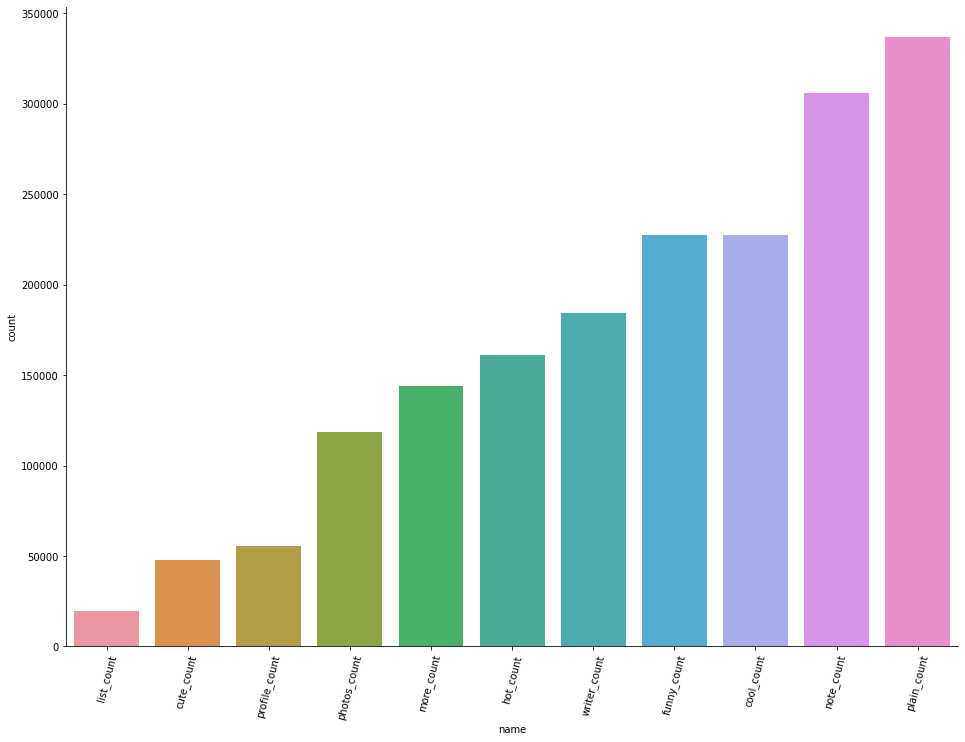

In [37]:
ax = sns.catplot(x="name", y="count", kind="bar", data=sorted_user_review_count_pd)
ax.set_xticklabels(rotation=75)

fig = plt.gcf()
fig.set_size_inches(16, 10)

plt.show()

#### Yelping Since Exploration

Here we group by year and explore the year joined by the Yelper.

In [40]:
user_with_year_df = clean_user_df.withColumn('yelping_since_year', year(col('yelping_since')))

In [44]:
yelping_since_counts = user_with_year_df.select(col('yelping_since_year')).groupBy('yelping_since_year').count().sort(col("count").desc())
yelping_since_counts.show(15, False)

+------------------+------+
|yelping_since_year|count |
+------------------+------+
|2015              |267267|
|2014              |250827|
|2016              |241414|
|2013              |221380|
|2012              |203180|
|2011              |185076|
|2017              |158881|
|2018              |122892|
|2010              |115106|
|2019              |75728 |
|2009              |68314 |
|2008              |34327 |
|2007              |17155 |
|2006              |6052  |
|2005              |1022  |
+------------------+------+
only showing top 15 rows



In [45]:
yelping_since_pd = yelping_since_counts.toPandas()

In [46]:
yelping_since_pd.head(10)

,yelping_since_year,count
0,2015,267267
1,2014,250827
2,2016,241414
3,2013,221380
4,2012,203180
5,2011,185076
6,2017,158881
7,2018,122892
8,2010,115106
9,2019,75728


In [47]:
yelping_since_sorted_pd = yelping_since_pd.sort_values(by="yelping_since_year", ascending=True)

#### Yelping Since Graph

Here we have a pretty nice distribution curve for this. We can see 2015 is the most common year of joining, with it decreasing on both ends. Not sure if this correlates with Yelp's popularity, but an interesting distribution of when users joined Yelp.

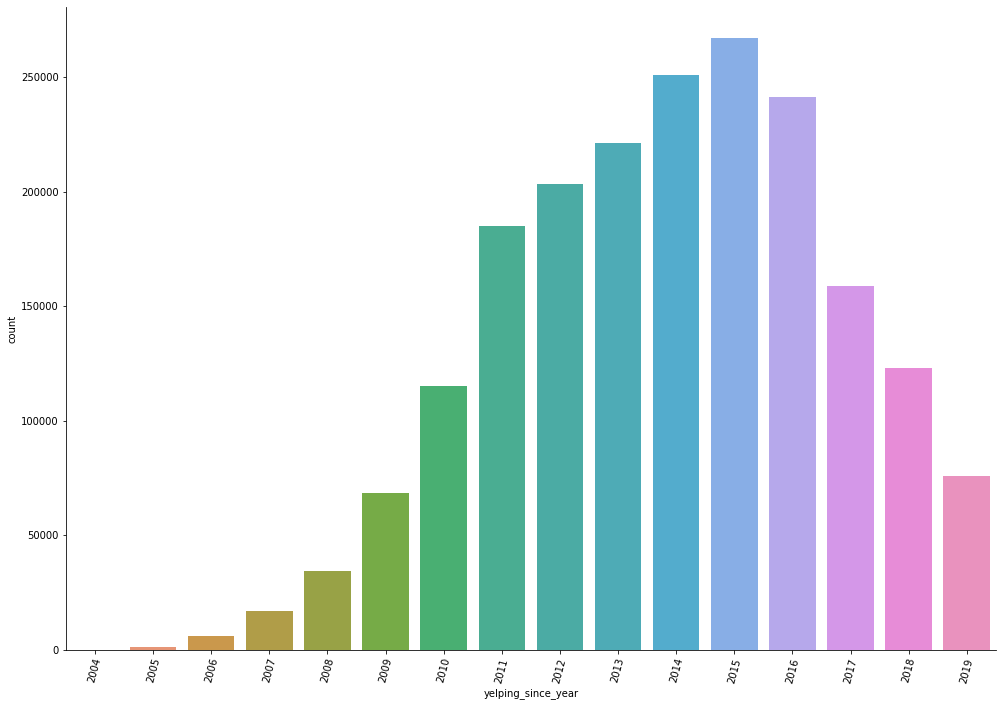

In [48]:
ax = sns.catplot(x="yelping_since_year", y="count", kind="bar", data=yelping_since_pd)
ax.set_xticklabels(rotation=75)

fig = plt.gcf()
fig.set_size_inches(16, 10)

plt.show()